In [1]:
from pyawd import VectorAcousticWaveDataset2D, VectorAcousticWaveDataset3D
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary

torch.manual_seed(0)
sns.set_theme()

In [2]:
device = 'cpu'
torch.set_default_device(device)

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return np.float32(self.X[idx]), np.float32(self.Y[idx])
    def __len__(self):
        return len(self.X)

In [36]:
train_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/train2D")
train_dataset._display_velocity_model = True
X = np.load("../../../local/datasets/AWD/train2D_interrogators_data.npy")
X = X.reshape((-1, 1, 40, 100))
Y = np.load("../../../local/datasets/AWD/train2D_epicenters.npy")
test_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/test2D")
test_dataset._display_velocity_model = True
X_test = np.load("../../../local/datasets/AWD/test2D_interrogators_data.npy")
X_test = X_test.reshape((-1, 1, 40, 100))
Y_test = np.load("../../../local/datasets/AWD/test2D_epicenters.npy")

In [37]:
print(X.shape)

(1000, 1, 40, 100)


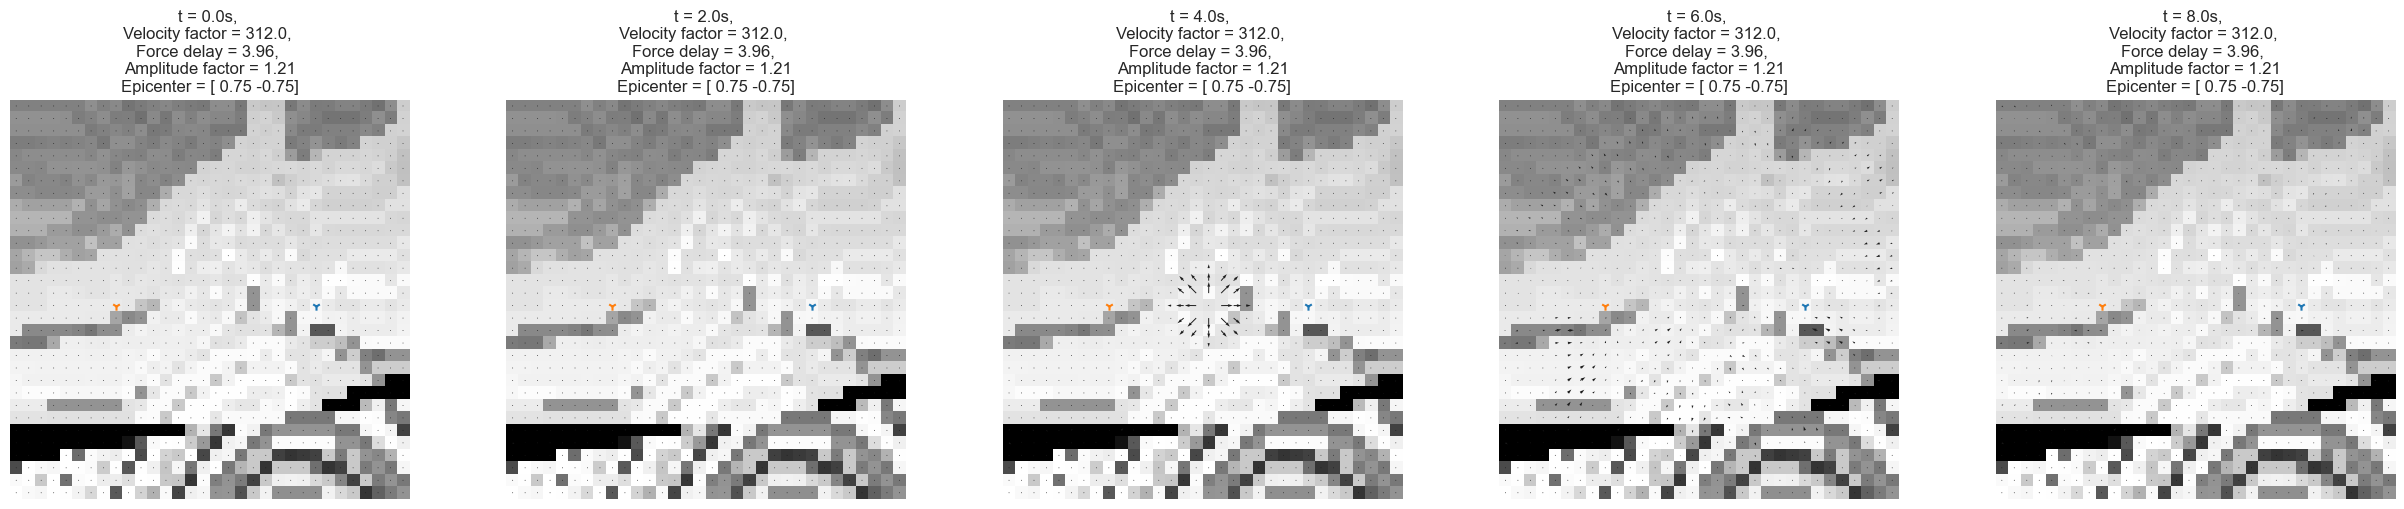

In [38]:
train_dataset.plot_item(0)

In [39]:
train = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [40]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [41]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred.squeeze(1), y.squeeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        pred = model(x)
        loss += loss_fn(pred.squeeze(1), y.squeeze(1)).item()
    return loss/len(X)      

In [61]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define convolutional layers
        self.conv1 = torch.nn.Conv2d(in_channels=X.shape[1], out_channels=16, kernel_size=3, padding=1)
        self.activation1 = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.activation2 = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully connected layers
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(2000, 2)
        self.activation3 = torch.nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation3(x)
        return x


model = CNN()
learning_rate = 1e-4
epochs = 100
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
losses = []

In [62]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            160
├─Tanh: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            1,160
├─Tanh: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            4,002
├─Tanh: 1-9                              --
Total params: 5,322
Trainable params: 5,322
Non-trainable params: 0

In [63]:
t = time()
for e in (pbar := tqdm(range(epochs))):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(model, test_loader))
    pbar.set_description("Loss: " + str(losses[-1])[:8])
t = time()-t

  0%|          | 0/100 [00:00<?, ?it/s]

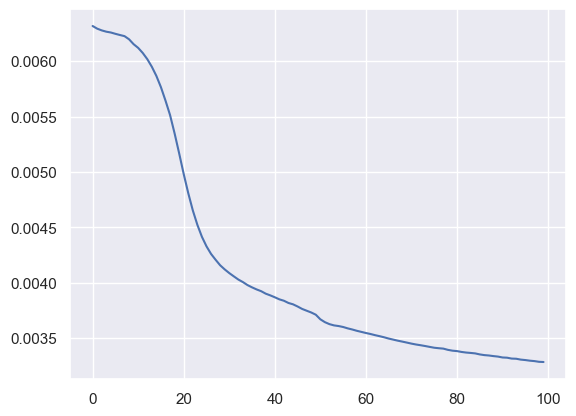

In [51]:
plt.plot(losses)
plt.savefig("../Results/CNN_learning.jpg", dpi=250)

NMSE: 0.5296248166025868


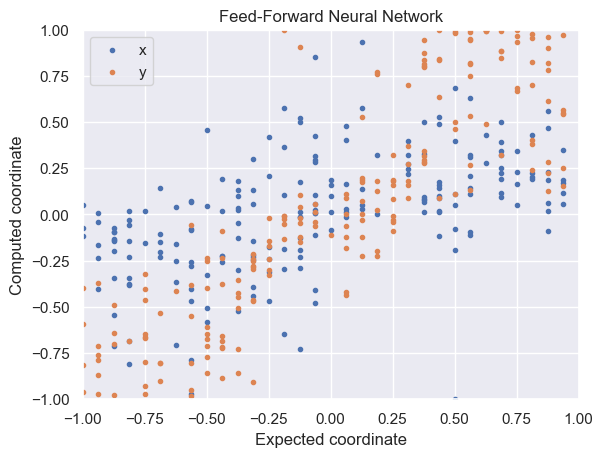

In [52]:
y_test = np.array([(i[0].item(), i[1].item()) for i in Y_test])
y_hat = np.array([model.forward(torch.Tensor(i).unsqueeze(0).to(device)).cpu().detach().numpy() for i in X_test])
y_hat = np.array([(i[:, 0].item(), i[:, 1].item()) for i in y_hat])
nmse = NMSELoss(y_test, y_hat)
print("NMSE:", nmse)
plt.scatter(y_test[:, 0], y_hat[:, 0], marker='.')
plt.scatter(y_test[:, 1], y_hat[:, 1], marker='.')
plt.legend(["x", "y"])
plt.xlabel("Expected coordinate")
plt.ylabel("Computed coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/CNN.jpg", dpi=250)

In [53]:
with open("../Results/results.csv", 'a') as f:
    f.write("CNN" + "," + str(nmse)[:7] + "," + str(t)[:7] + "," + str(nmse*t)[:7] + "\n")

In [54]:
i = 0
print("Expected epicenter:", test_dataset.get_epicenter(i))
print("\t- CNN:\t\t", y_hat[i])

Expected epicenter: [0.     0.4375]
	- CNN:		 [0.15890458 0.83379686]
